# Objective
### The aim of this notebook is to generate the basis for the experimentally evaluated T1,T2 pair of values

In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import utils

import sys#this helps with reading data from multiple places
sys.path.insert(0, './mri-sim-py/epg/')#need to add these paths in the server folder
sys.path.insert(0, 'bart/python')#do we need bart here right now
sys.path.insert(0, './mri-sim-py/t1t2shuffle/')#the main function

import t1t2shuffle as t2sh
import epg
import cfl #useful in data storage and reading, dont need it right now
import time

from tqdm import tqdm

In [2]:
def nrmse(x1, x2):
    return np.linalg.norm(x1.ravel() - x2.ravel()) / np.linalg.norm(x1.ravel())

In [3]:
T2_values = np.load('subject2/Subject2_T2_vals_experimental.npy')#loading the experimental evaluated T2 values
T1_values = np.load('subject2/Subject2_T1_vals_experimental.npy')
mask = np.load('subject2/Subject2_mask_experimental.npy')
T1T2_vals = np.zeros((2,len(T1_values)))

T1T2_vals[0,:] = T1_values 
T1T2_vals[1,:] = T2_values
print(T1T2_vals.shape)

(2, 35818)


In [4]:
import sys#this helps with reading data from multiple places
sys.path.insert(0, './mri-sim-py/epg/')#need to add these paths in the server folder
sys.path.insert(0, 'bart/python')#do we need bart here right now
sys.path.insert(0, './mri-sim-py/t1t2shuffle/')#the main function

import t1t2shuffle as t2sh
import epg

def myfun(t1t2):
    sig_dict = {
        'T1': t1t2[0],
        'T2': t1t2[1],
    }
    TR_vals = np.array([860, 1830, 2800])
    TRs = TR_vals
    N_TRs = 3#number of reptitions to get the T1 weighting
    TE = 9.1*2
    ETL = 16
    angles_rad = np.ones((ETL))*180*np.pi/180
    #update the code for stopping the driven equil case
    signal = t2sh.t1t2shuffle2(angles_rad, TE, TRs, 1, T1= sig_dict['T1'], T2 = sig_dict['T2'], driven_equil = False, fr_sign = False)
    return signal/np.linalg.norm(signal)

In [5]:
par_jobs = 32
from multiprocessing import Pool
with Pool(par_jobs) as p:
    result_dict = list((tqdm(p.imap(myfun, T1T2_vals.T), total=len(T1T2_vals), leave=True)))

35818it [00:05, 6643.68it/s]         


In [6]:
X_sim3 = np.array(result_dict).T
print(X_sim3.shape)

(48, 35818)


In [7]:
#finding the basis vector by using the SVD decomposition, the u matrix contains the basis vectors
u, s, vh = np.linalg.svd(X_sim3, full_matrices=True)
print(u.shape, s.shape, vh.shape)

basis3 = u

(48, 48) (48,) (35818, 35818)


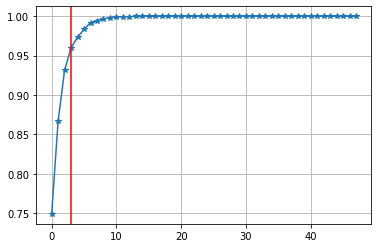

In [123]:
plt.plot(np.cumsum(s)/sum(s), marker='*')
plt.axvline(x=3, c= 'r')
plt.grid()
plt.show()

In [8]:
np.save('subject2/X_simulated_experimentalT1_T2.npy', X_sim3)#no fast recovery, save the data otherwise it takes a lot of time to simulate
np.save('subject2/basis_experimentalT1_T2.npy',basis3)


(35818, 5)


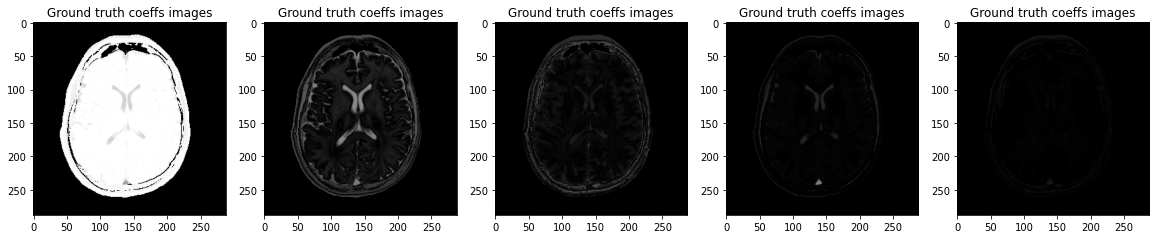

In [55]:
# trials for generating the true ground truth coefficient images
K=5#first 5 basis vectors

Phi = basis3[:,:K]
X_proj_coeffs = np.dot(Phi.T, X_sim3).T#take the projection coefficients along the first 5 basis vectors
print(X_proj_coeffs.shape)
GT_coeff_img = np.zeros([288,288,5])

for index in range(K):
    plt.figure(1, figsize=(20,5))
    plt.subplot(1, K, index+1)
    Im_synthetic = np.zeros([288,288])
    Im_synthetic[np.nonzero(mask)] = X_proj_coeffs[:,index]
    GT_coeff_img[:,:,index] = Im_synthetic#*porton_image_data[:,:,slice_index]
    plt.imshow(np.abs(Im_synthetic),cmap=plt.get_cmap('gray'), vmin=0, vmax=1) 
    plt.title('Ground truth coeffs images')

#GT_coeff_img = GT_coeff_img/np.amax(np.abs(GT_coeff_img))

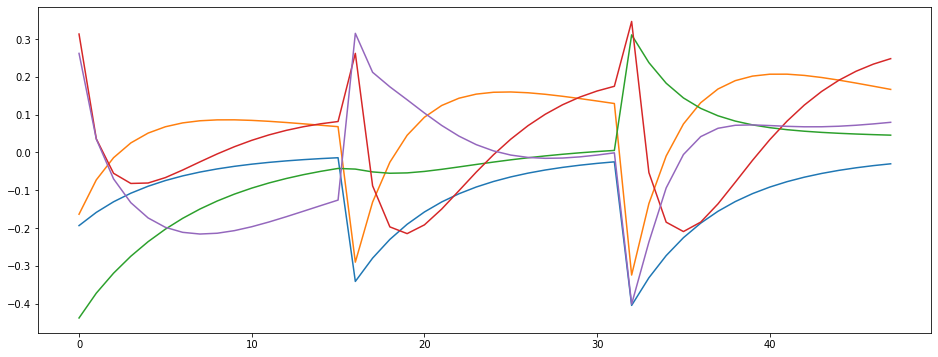

In [51]:
plt.figure(figsize=(16,6))
plt.plot(basis3[:,:5])
plt.show()

Shape of simulated signal evolution:  (48, 35818)


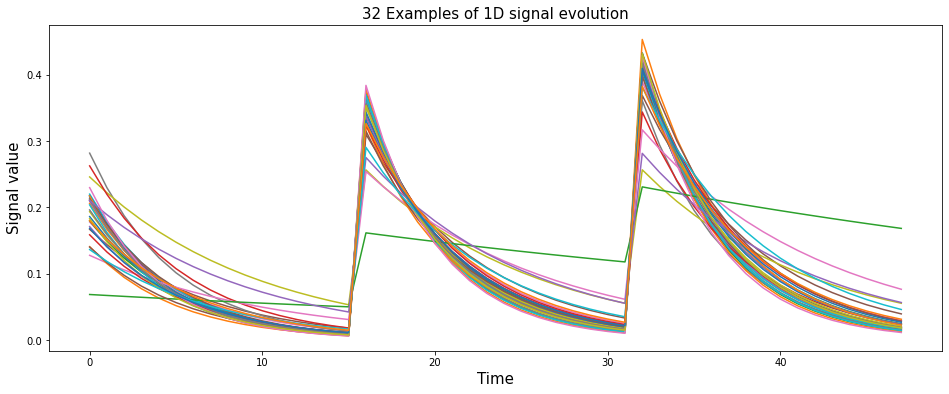

In [7]:
N_plot = 32#number of signal evolutions to be plotted
ridx = np.random.permutation(X_sim3.shape[1])#randomly select 32 signal evolutions
print('Shape of simulated signal evolution: ',X_sim3.shape)
#X_reshape = np.reshape(X_sim, [N_TRs, ETL, T1T2_vals])
#plot any random 32 single evolutions
plt.figure(figsize=(16,6))
plt.plot(X_sim3[:,ridx[:N_plot]]);
plt.title('32 Examples of 1D signal evolution',fontsize=15)
plt.xlabel('Time',fontsize=15)
plt.ylabel('Signal value',fontsize=15)
plt.show()

In [11]:
#spin echo signal evolution definition
def spin_echo(T1T2_vals, TE, TR):
    return np.exp(-TE / T1T2_vals[1,:]) * (1 - np.exp(-(TR-TE)/T1T2_vals[0,:]))

#inverse recovery spin echo used for generating T1 and T2 FLAIR images
def IR_spin_echo(T1T2_vals, TE, TR, TI):
    return (1 - 2 * np.exp(-(TI)/T1T2_vals[0,:]) + np.exp(-TR/T1T2_vals[0,:]))*np.exp(-TE / T1T2_vals[1,:]) 

In [69]:
A = np.dot(Phi.T, X_sim3).T
def linear_coeffs(A,spin_echo_out):
    q, qresid, qrank, qs = np.linalg.lstsq(A, spin_echo_out,rcond=None)#least squares fitting to find the linear combination 
    nrmse_err = nrmse( np.dot(A,q) , spin_echo_out)
    return q, nrmse_err

In [70]:
#generating the training input and outputs for the NN to learn, this is for the real valued case
Y_T1_image = spin_echo(T1T2_vals, 9, 150)#find the actual spin evolution through EPG algorithm, approximated through that spin echo function defined earlier
Y_T2_image = spin_echo(T1T2_vals, 150, 8000)  

Y_T1_FLAIR = IR_spin_echo(T1T2_vals, 10, 2100, 880)
Y_T2_FLAIR = IR_spin_echo(T1T2_vals, 110, 8000, 2200)

In [71]:
#linear combination coefficients
T1_image_linear_coeffs, err_T1w = linear_coeffs(A,Y_T1_image)
T2_image_linear_coeffs, err_T2w  = linear_coeffs(A,Y_T2_image)
T1_FLAIR_linear_coeffs, err_T1F  = linear_coeffs(A,Y_T1_FLAIR)
T2_FLAIR_linear_coeffs, err_T2F = linear_coeffs(A,Y_T2_FLAIR)

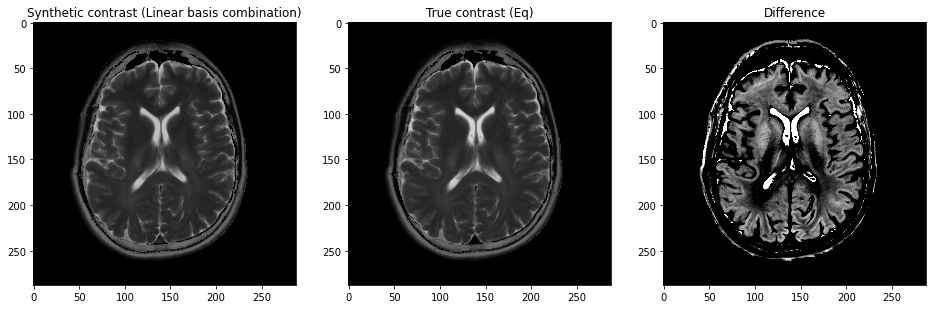

T2 contrast images


In [105]:
plt.figure(figsize=(16,6))

Im_synthetic1 = np.zeros([288,288])
Im_synthetic1[np.nonzero(mask)] = np.dot(A,T2_image_linear_coeffs)
plt.subplot(1,3,1)
plt.imshow(Im_synthetic1,cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.title('Synthetic contrast (Linear basis combination)')

plt.subplot(1,3,2)
Im_synthetic = np.zeros([288,288])
Im_synthetic[np.nonzero(mask)] = Y_T2_image
plt.imshow(Im_synthetic,cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.title('True contrast (Eq)')

plt.subplot(1,3,3)
plt.imshow(Im_synthetic - Im_synthetic1,cmap=plt.get_cmap('gray'), vmin=0, vmax=1*0.01)#.5*np.max(np.abs(Im_synthetic))) 
plt.title('Difference')
plt.show()

print('T2 contrast images')

In [106]:
print(nrmse(Im_synthetic1,Im_synthetic))

0.062436996313863936


In [107]:
True_contrast_T2_image = Im_synthetic;#image from the spin echo equation
LC_T2_image = Im_synthetic1;#linear combination image

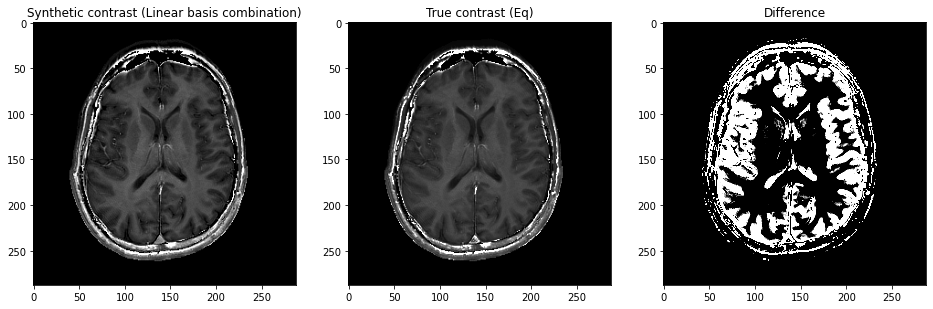

T1 contrast images


In [108]:
plt.figure(figsize=(16,6))

Im_synthetic1 = np.zeros([288,288])
Im_synthetic1[np.nonzero(mask)] = np.dot(A,T1_image_linear_coeffs)
plt.subplot(1,3,1)
plt.imshow(Im_synthetic1,cmap=plt.get_cmap('gray'), vmin=0, vmax=0.5)
plt.title('Synthetic contrast (Linear basis combination)')

plt.subplot(1,3,2)
Im_synthetic = np.zeros([288,288])
Im_synthetic[np.nonzero(mask)] = Y_T1_image
plt.imshow(Im_synthetic,cmap=plt.get_cmap('gray'), vmin=0, vmax=0.5)
plt.title('True contrast (Eq)')

plt.subplot(1,3,3)
plt.imshow(Im_synthetic - Im_synthetic1,cmap=plt.get_cmap('gray'), vmin=0, vmax=0.5*0.01)#.5*np.max(np.abs(Im_synthetic))) 
plt.title('Difference')
plt.show()

print('T1 contrast images')

In [109]:
print(nrmse(Im_synthetic1,Im_synthetic))

0.21669883385872957


In [110]:
True_contrast_T1_image = Im_synthetic;
LC_T1_image = Im_synthetic1;#linear combination image

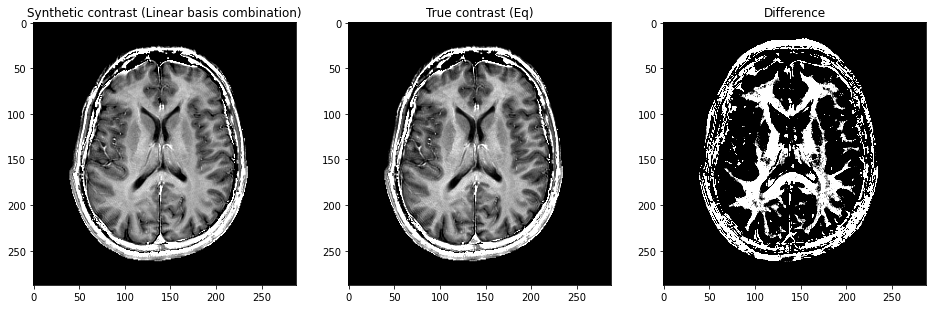

T1 FLAIR images


In [111]:
plt.figure(figsize=(16,6))

Im_synthetic1 = np.zeros([288,288])
Im_synthetic1[np.nonzero(mask)] = np.dot(A,T1_FLAIR_linear_coeffs)
plt.subplot(1,3,1)
plt.imshow(Im_synthetic1,cmap=plt.get_cmap('gray'), vmin=0, vmax=0.5)
plt.title('Synthetic contrast (Linear basis combination)')

plt.subplot(1,3,2)
Im_synthetic = np.zeros([288,288])
Im_synthetic[np.nonzero(mask)] = Y_T1_FLAIR
plt.imshow(Im_synthetic,cmap=plt.get_cmap('gray'), vmin=0, vmax=0.5)
plt.title('True contrast (Eq)')

plt.subplot(1,3,3)
plt.imshow(Im_synthetic - Im_synthetic1,cmap=plt.get_cmap('gray'), vmin=0, vmax=0.5*0.01)#.5*np.max(np.abs(Im_synthetic))) 
plt.title('Difference')
plt.show()

print('T1 FLAIR images')

In [112]:
print(nrmse(Im_synthetic1,Im_synthetic))

0.05406889298599796


In [113]:
True_contrast_T1_FLAIR = Im_synthetic;#image from the spin echo equation
LC_T1_FLAIR = Im_synthetic1;#linear combination image

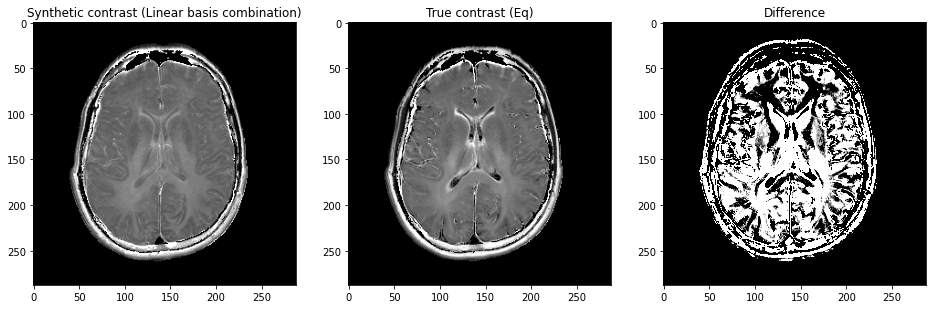

T2 FLAIR images


In [114]:
plt.figure(figsize=(16,6))

Im_synthetic1 = np.zeros([288,288])
Im_synthetic1[np.nonzero(mask)] = np.dot(A,T2_FLAIR_linear_coeffs)
plt.subplot(1,3,1)
plt.imshow(Im_synthetic1,cmap=plt.get_cmap('gray'), vmin=0, vmax=0.5)
plt.title('Synthetic contrast (Linear basis combination)')

plt.subplot(1,3,2)
Im_synthetic = np.zeros([288,288])
Im_synthetic[np.nonzero(mask)] = Y_T2_FLAIR
plt.imshow(Im_synthetic,cmap=plt.get_cmap('gray'), vmin=0, vmax=0.5)
plt.title('True contrast (Eq)')

plt.subplot(1,3,3)
plt.imshow(Im_synthetic - Im_synthetic1,cmap=plt.get_cmap('gray'), vmin=0, vmax=0.5*0.01)#.5*np.max(np.abs(Im_synthetic))) 
plt.title('Difference')
plt.show()

print('T2 FLAIR images')

In [115]:
print(nrmse(Im_synthetic1,Im_synthetic))

0.20591381876475745


In [116]:
True_contrast_T2_FLAIR = Im_synthetic;#image from the spin echo equation
LC_T2_FLAIR = Im_synthetic1;#linear combination image

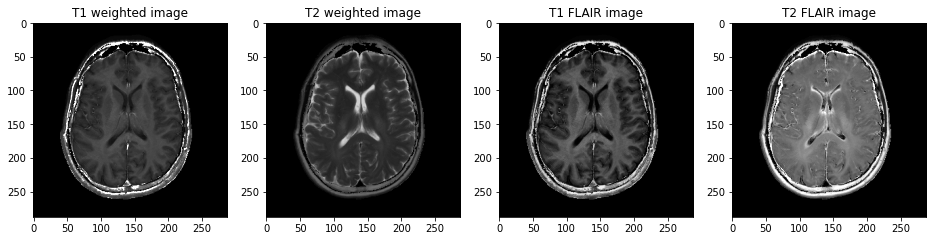

         True contrast images using estimated T1,T2 values and without PD for subject 2


In [117]:
plt.figure(figsize=(16,12))
plt.subplot(1,4,1)
plt.imshow(np.abs(True_contrast_T1_image), cmap='gray',vmax = 0.5,vmin=0)
plt.title('T1 weighted image')

plt.subplot(1,4,2)
plt.imshow(np.abs(True_contrast_T2_image), cmap='gray',vmax = 1,vmin=0)
plt.title('T2 weighted image')

plt.subplot(1,4,3)
plt.imshow(np.abs(True_contrast_T1_FLAIR), cmap='gray',vmax = 1,vmin=0)
plt.title('T1 FLAIR image')

plt.subplot(1,4,4)
plt.imshow(np.abs(True_contrast_T2_FLAIR), cmap='gray',vmax = 0.5,vmin=0)
plt.title('T2 FLAIR image')

plt.show()

print('         True contrast images using estimated T1,T2 values and without PD for subject 2')

In [118]:
PD_map = np.load('subject2/Subject2_PD.npy')

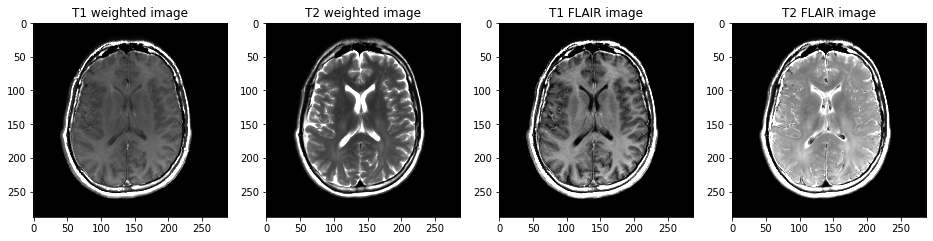

         True contrast images using estimated T1,T2 values and with PD for subject 2


In [119]:
plt.figure(figsize=(16,12))
plt.subplot(1,4,1)
plt.imshow(np.abs(PD_map*True_contrast_T1_image[:,:]), cmap='gray',vmax = 0.0003,vmin=0)
plt.title('T1 weighted image')

plt.subplot(1,4,2)
plt.imshow(np.abs(PD_map*True_contrast_T2_image[:,:]), cmap='gray',vmax = 0.0005,vmin=0)
plt.title('T2 weighted image')

plt.subplot(1,4,3)
plt.imshow(np.abs(PD_map*True_contrast_T1_FLAIR[:,:]), cmap='gray',vmax = 0.0005,vmin=0)
plt.title('T1 FLAIR image')

plt.subplot(1,4,4)
plt.imshow(np.abs(PD_map*True_contrast_T2_FLAIR[:,:]), cmap='gray',vmax = 0.0003,vmin=0)
plt.title('T2 FLAIR image')

plt.show()

print('         True contrast images using estimated T1,T2 values and with PD for subject 2')

In [100]:
#saving the different contrast images
np.save('subject2/48ETL_semc_True_contrast_T1_FLAIR.npy',True_contrast_T1_FLAIR*PD_map)
np.save('subject2/48ETL_semc_True_contrast_T2_FLAIR.npy',True_contrast_T2_FLAIR*PD_map)
np.save('subject2/48ETL_semc_True_contrast_T1_image.npy',True_contrast_T1_image*PD_map)
np.save('subject2/48ETL_semc_True_contrast_T2_image.npy',True_contrast_T2_image*PD_map)